Course: <span style="color:crimson"> Current and Future Trends in Extreme Weather </span> (EAS-G574 - Indiana University - Fall 2022) <br />
Instructor: <span style="color:crimson"> Prof. Travis O'Brien </span> <br />
Student: Trung Nguyen
<p style="text-align: center;">
<span style="color:blue; font-size:1.5em"> GRAD MAJOR ASSIGNMENT </span> <br />
<span style="color:black; font-size:1.5em"> Contextualizing Extremes in the Media </span> <br />
Due: Thu Dec 15, 2022 2:40pm <br />
</p>

**<span style="color:crimson">  The goal : </span>**
<p style="text-align: justify;"> 
This jupyter notebook accompanies the website that conveys the information on the extreme heavy rainfall event in June 2021 in Bloomington (Indiana). 
Specifically, this notebook presents a data analysis of RX2day, using a maximum likelihood non-stationary Generalized Extreme Value (GEV) approach, in which the analysis code is combined with discussion of the approach.
Although the target audiences for this notebook are climate scientists who are familiar with the GEV approach, the author hope that this notebook will be enjoyable for any reader, to some extent.
</p>

<span style="color:blue; font-size:1.5em"> **0. Getting set up** </span>  <br />
* All python libraries and self-written functions are "imported" in the cell **#1** below.
* The **gev_functions()** contains all the functions that I wrote in the framework of class G574 (Fall 2022, instructed by Prof. Travis O'Brien). These functions were verified and discussed in the Homework #1 to #3 of this class.

In [1]:
# "Classical" numpy and matplotlib:
import numpy as np
import matplotlib.pyplot as plt

# All of my GEV functions written are stored in gev_functions.py
import gev_functions

# Use csv reader from pandas for reading data
import pandas as pd

# For add the KDE to plot
from scipy import stats

# Mann-Kendall trend test
import pymannkendall as mk

<span style="color:blue; font-size:1.5em"> **1. Extreme rainfall event in June 2021**  </span>  <br />
* To study the extreme rainfall event in Bloomington (Indiana), in June 2021, the RX2day data will be used.
* RX2day is maximum 2-day precipitation total which is used in the same sense as RX1day or RX5day from ETCCDI Climate Change Indices **[1]** to detect the changing of precipitation extremes.
* In this study, annual RX2day series from 1895 to 2022 for Bloomington, Indiana is used. This data is provided by Prof. Travis O'Brien and discussed in **[2]**.
* In the cell **#2** below, the R2Xday data is loaded and its timeseries as well as its histogram are displayed (Figure 1 and Figure 2).
* In Figure 1, the extreme rainfall event in June 2021 can be easily recognized by its magnitude (i.e., marked as orange circle). It has rainfall amount of 154.9 mm per two days (i.e., 18-19 June 2021). This intensity reached the threshold (i.e. grey line) that only two events during the last 128 years can be higher.
* Histograms in Figure 2 also highlights this extreme event in June 2021 belongs to the right-tail of the distribution (i.e., in range of bin 140 to 160 mm).

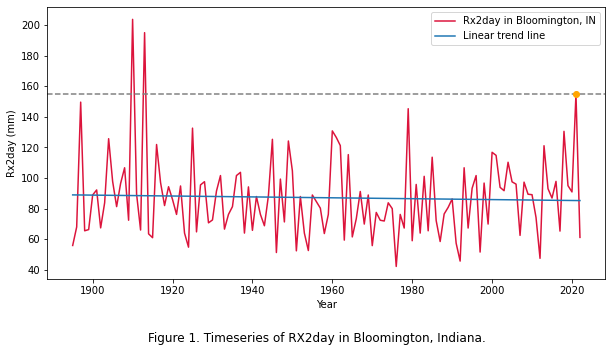

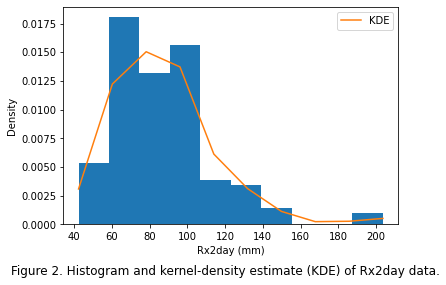

In [2]:
# Load RX2day data (provided by Prof. Travis O'Brien)
df = pd.read_csv('/home/data/bloomington_rx2day.csv',header=0)

# Get #Year and #Rx2day as time (t) and variable (x)
t = df['#Year'].values
x = df['Rx2day [in]'].values

# Convert inches to mm (SI unit)
x = x * 25.4

# Add simple linear trendline
z = np.polyfit(t, x, 1)
p = np.poly1d(z)

# Add Kernel Density Estimates (KDE)
kde = stats.gaussian_kde(x)
xx = np.linspace(np.nanmin(x), np.nanmax(x), 10)

# Plot the RX2day data
plt.figure (figsize=(10,5))
plt.plot(t, x, color='crimson',label='Rx2day in Bloomington, IN')

# Add trendline to plot
plt.plot(t, p(t),label='Linear trend line')

# Add the emphasis of extreme event in June 2021
plt.axhline(y=x[-2], color='grey', linestyle='--')
plt.plot(t[-2],x[-2], color='orange', marker='o', linestyle=None)

# Decoration
plt.xlabel('Year')
plt.ylabel('Rx2day (mm)')
plt.legend()
caption='Figure 1. Timeseries of RX2day in Bloomington, Indiana.'
plt.figtext(0.5, -0.05, caption, wrap=True, horizontalalignment='center', fontsize=12)
plt.show()

# Plot a PDF of the Rx2day values
plt.hist(x, density=True)
plt.plot(xx, kde(xx), label="KDE")
plt.ylabel('Density')
plt.xlabel('Rx2day (mm)')
plt.legend()
caption='Figure 2. Histogram and kernel-density estimate (KDE) of Rx2day data.'
plt.figtext(0.5, -0.05, caption, wrap=True, horizontalalignment='center', fontsize=12)
plt.show()

<span style="color:blue; font-size:1.5em"> **2. Return interval of this event**  </span>  <br />
* To estimate the return interval of this extreme rainfall event (in 2021), the non-stationary Generalized Extreme Value (GEV) approach is used. Codes in cell **#3** show how the return interval of **about 43 years** is found.
* Firstly, the RX2day data will be fitted to a non-stationary GEV distribution with the assumption of linearly increasing $\mu$ with time. The parameters of this non-stationary GEV distribution is estimated by the maximum likelihood estimate (MLE) approach. The function *gev_ns_mle()* that developed and tested in homework #3 is used again. Secondly, with founded parameters, the cumulative distribution function (CDF) and, survival functions (SF=1-CDF) can be retrieved. The SF value is about 0.023 in this case. Finally, as the data is on yearly frequency (i.e., one sample per year), the return interval can be calculated as 1/SF (i.e., the result is ~ 42.975 years).
* It's interesting that this return interval is quite the same as simple recurrence intervals regards to orders of magnitude. Recurrence Interval can be calculated as the number of years, plus one, divided by the magnitude rank of the current extreme event. From the Figure 1, we easily see the rank 3<sup>th</sup> of the event and with 128 years of data, we have: Recurrence Interval = (Years + 1) / Rank = 129/3 = 43 years.
* Another thing that should be noted is the posibility that my optimization routine gets stuck in a local minimum (i.e., occurred when applying to RX7day in Risser et al., (2017)). The Nelder-Mead algorithm used for solvers of optimization should be revised in further study (i.e., as it *"can converge to non-stationary points"*) [[4]](https://en.wikipedia.org/wiki/Nelder%E2%80%93Mead_method).

In [3]:
# Initial guesses for the nonstationary GEV distribution parameters
cmu = 0.001           # Start with this assumption
mu0 = np.nanmean(x)   # Using the mean
sigma = np.nanstd(x)  # Using the standard deviation
xi = 0.05             # The second guesses
params0 = [cmu, mu0, sigma, xi]
    
# The boundary of parameters that we want to investigate
scale = 1000
bounds = [(cmu/scale,cmu*scale),(mu0-scale,mu0+scale),(sigma/scale,sigma*scale),(xi/scale,xi*scale)]
    
# Use my functions to estimate parameters
mle, cmu_o, mu0_o, sigma_o, xi_o = gev_functions.gev_ns_mle(x, t, params0, bounds)

# Print the parameters
print ("MLE = ",mle, " cmu = ", cmu_o, " mu0 = ", mu0_o, " sigma = ", sigma_o, "xi =", xi_o)

# Get the non-stationary GEV CDF based on found parameters and RX2day of June 2021
cdf=gev_functions.gev_ns_cdf(x[-2], t[-2], cmu_o, mu0_o, sigma_o, xi_o)

# Get survival functions
sf = 1 - cdf

# Get return interval 
ri = 1 / sf
print ("Return interval : ", ri, " years")

MLE =  582.2490336541362  cmu =  1.0000000000000002e-06  mu0 =  74.89253072481358  sigma =  19.795127996989265 xi = 0.03963061784067837
Return interval :  42.975002975666754  years


<span style="color:blue; font-size:1.5em"> **3. Risk ratio of this event**  </span>  <br />
* Risk ratio is the most straightforward metric in climate change attribution studies (Pall et al., 2014)[5]. Cell #4 presents how the risk ratio of the extreme rainfall event in June 2021 in Bloomington is calculated.
* The non-stationary GEV distribution (i.e., using founded parameters in the previous section) is used to calculate the probability density function of the RX2day amount of 154.9 mm (i.e., the event in June 2021) with its year of 2021 as well as of 1895 (i.e., the time before global warming). Hence, the risk ratio is the ratio between these two probability (i.e., P<sup>new</sup> and P<sup>old</sup>) can be calculated. This is one advantage of covariate-based statistical models (i.e., in this case, the covariate variable is time) in which we can isolate the potential effect of anthropogenic warming on the probability of extreme rainfall events as the one in June 2021 in Bloomington, IN.
* The risk ratio of **about 1.0** is founded in this case (i.e., same as we consider 1950 instead of 1895). That is to say, the risk of the extreme rainfall event occurred in June 2021, was, on average, about the same as it would have been in the absense of human-induced climate change.
* Of course, as mentioned above, further tests on the goodness-of-fit of current non-stationary GEV distribution are required, before emphasize on the current found risk ratio. Moreover, what will happen if we consider only the last 100 years (i.e., since 1922) with the doubt of data observation quality before 1920? 

In [4]:
# First estimating the probability of the Rx2day total in the current year (2021)
p1=gev_functions.gev_ns_cdf(x[-2], t[-2], cmu_o, mu0_o, sigma_o, xi_o)

# Second, a similar probability, but in a counterfactual world 
# with but earlier (say, t[0]=1895 ) CO2 concentrations (not global warming yet)
p0=gev_functions.gev_ns_cdf(x[-2], t[0], cmu_o, mu0_o, sigma_o, xi_o)

# Calculate the risk ratio: 
rr = p1/p0
print ("Risk ratio : ",rr)

Risk ratio :  0.9999998708261899


<span style="color:blue; font-size:1.5em"> **4. Discussions**  </span>  <br />
* To the last point of discussion on "whether ordinary linear regression would have been a valid alternative to the non-stationary GEV approach", the Mann-Kendall trend test is carried out as in cell **#5**. The result of "no trend" and small Theil-Sen slope of ~0.0082 for the current RX2day supports the simple linear trend line in Figure 1.
* As we can see, in this case of current RX2day data series, we can expect the stationary of RX2day through time, as well as, the mean values of its distribution. Further investigations on confident intervals (e.g., using bootstrap resampling technique) might confirm this point. Therefore, the ordinary linear regression can be an alternative to the non-stationary GEV applied here. 

# Perform Mann-Kendall Trend Test
mk.original_test(x)

<span style="color:blue; font-size:1.2em"> **References**  </span>  <br />
1. ETCCDI Climate Change Indices, link http://etccdi.pacificclimate.org/list_27_indices.shtml, last access date 15 Dec 2022.
2. Discussion of Intense rainfall and flooding occurred in Bloomington, IN: https://github.com/taobrienlbl/bloomington_2021_flood_statement/blob/main/analysis.md, last access date 15 Dec 2022.
3. Example of calculating return level of extreme precipitation: https://sites.uci.edu/alexm/teaching-interests/calculating-return-level-of-extreme-precipitation-and-temperature-using-extrem-events-analysis/, last access date 15 Dec 2022.
4. Nelder–Mead method: https://en.wikipedia.org/wiki/Nelder%E2%80%93Mead_method, last access date 15 Dec 2022.
5. Pall, P., Wehner, M. F., & Stone, D. A. (2014). Probabilistic extreme event attribution. In P. Pall (Eds.), Dynamics and predictability of large-scale, high-impact weather and climate events (pp. 37–46). Cambridge: Cambridge University Press